In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam

# Load the stored DataFrame using pickle
with open('MaldiniNet.pickle', 'rb') as f:
    df = pickle.load(f)

df['home_advantage'] = df['home_xG'] - df['away_xG']

# Calculate the mean home advantage per home team for each season
mean_home_advantages = df.groupby(['season', 'home_team'])['home_advantage'].mean().reset_index()

# Normalize home advantage values
scaler = StandardScaler()
normalized_home_advantages = scaler.fit_transform(mean_home_advantages['home_advantage'].values.reshape(-1, 1))

# Create a mapping dictionary of (season, team) tuple to normalized home advantage
season_team_home_advantage_mapping = {
    (season, team): normalized_home_advantages[i][0] for i, (season, team) in enumerate(mean_home_advantages[['season', 'home_team']].values)
}

# Map normalized home advantage values back to the main DataFrame using (season, home_team) as keys
df['home_advantage'] = df.apply(lambda row: season_team_home_advantage_mapping.get((row['season'], row['home_team']), np.nan), axis=1)

df = df.drop(['date', 'league', 'home_xG', 'away_xG'], axis=1)

df[['home_win_prob', 'draw_prob', 'away_win_prob']] = df[['home_win_prob', 'draw_prob', 'away_win_prob']].astype(float)

# Identify and drop subsequent duplicate columns, keeping the first instance
df = df.loc[:, ~df.columns.duplicated(keep='first')]

df = df[df['draw_prob'] <= 0.40]


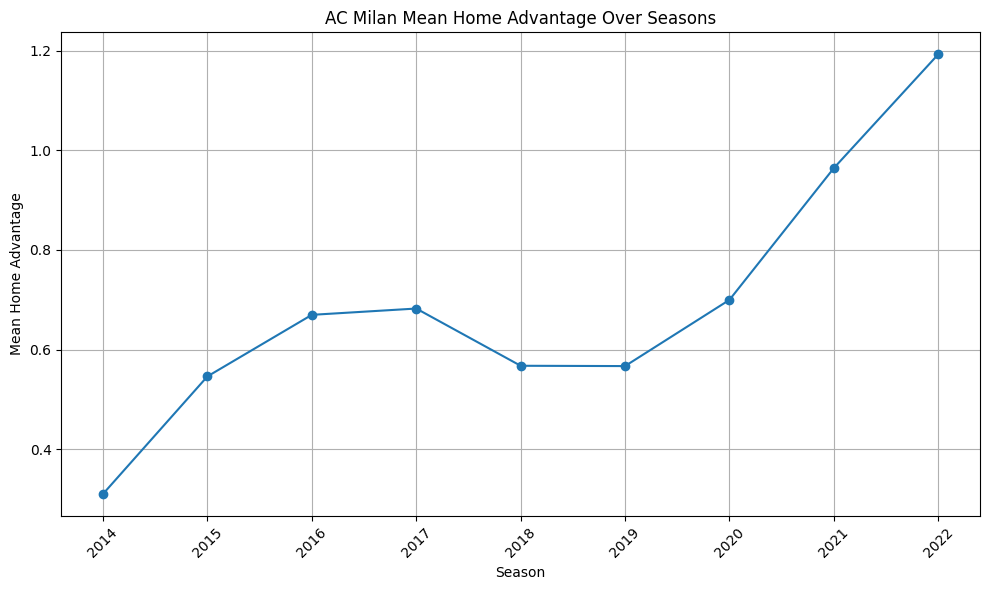

In [13]:
from matplotlib import pyplot as plt

ac_milan_advantages = mean_home_advantages[mean_home_advantages['home_team'] == 'AC Milan']

plt.figure(figsize=(10, 6))
plt.plot(ac_milan_advantages['season'], ac_milan_advantages['home_advantage'], marker='o')
plt.title('AC Milan Mean Home Advantage Over Seasons')
plt.xlabel('Season')
plt.ylabel('Mean Home Advantage')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

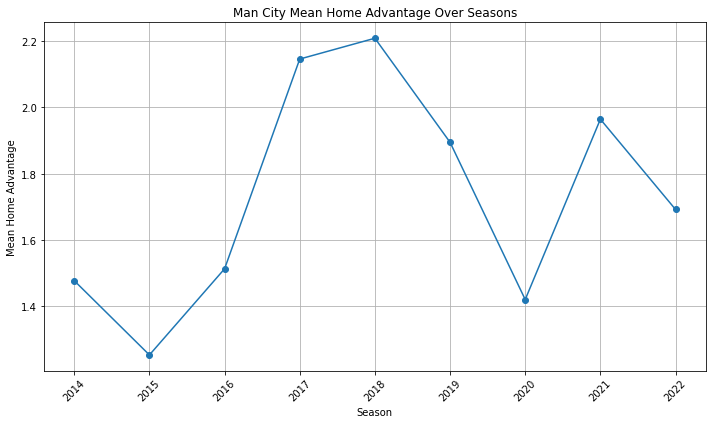

In [102]:
man_city_advantages = mean_home_advantages[mean_home_advantages['home_team'] == 'Manchester City']

plt.figure(figsize=(10, 6))
plt.plot(man_city_advantages['season'], man_city_advantages['home_advantage'], marker='o')
plt.title('Man City Mean Home Advantage Over Seasons')
plt.xlabel('Season')
plt.ylabel('Mean Home Advantage')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

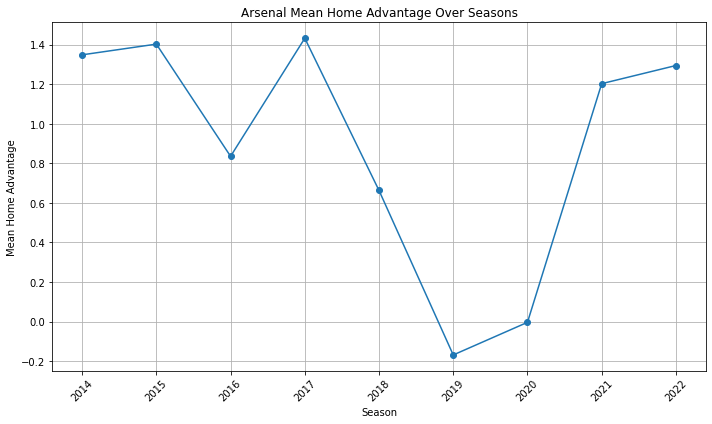

In [103]:
arsenal_advantages = mean_home_advantages[mean_home_advantages['home_team'] == 'Arsenal']

plt.figure(figsize=(10, 6))
plt.plot(arsenal_advantages['season'], arsenal_advantages['home_advantage'], marker='o')
plt.title('Arsenal Mean Home Advantage Over Seasons')
plt.xlabel('Season')
plt.ylabel('Mean Home Advantage')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
teams = list(set(df['home_team'].unique()) | set(df['away_team'].unique()))
le.fit(teams)


# Transform and store the outputs in a dictionary
team_encoding_dict = {
    'teams': teams,
    'encoded_teams': le.transform(teams)
}


df['home_team'] = le.transform(df['home_team'])
df['away_team'] = le.transform(df['away_team'])

In [15]:
len(df.columns)

47

<h2>
Data Exploration


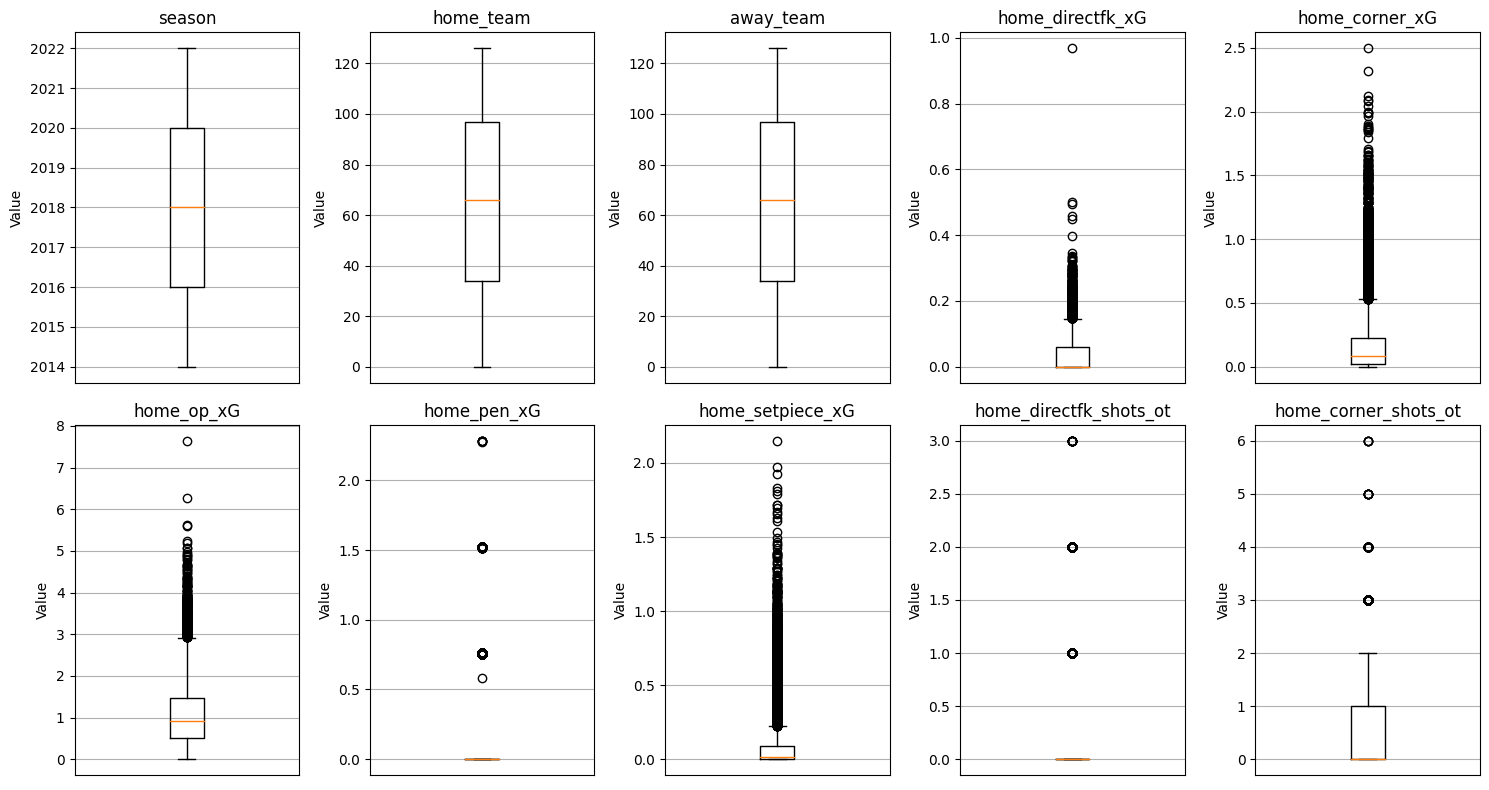

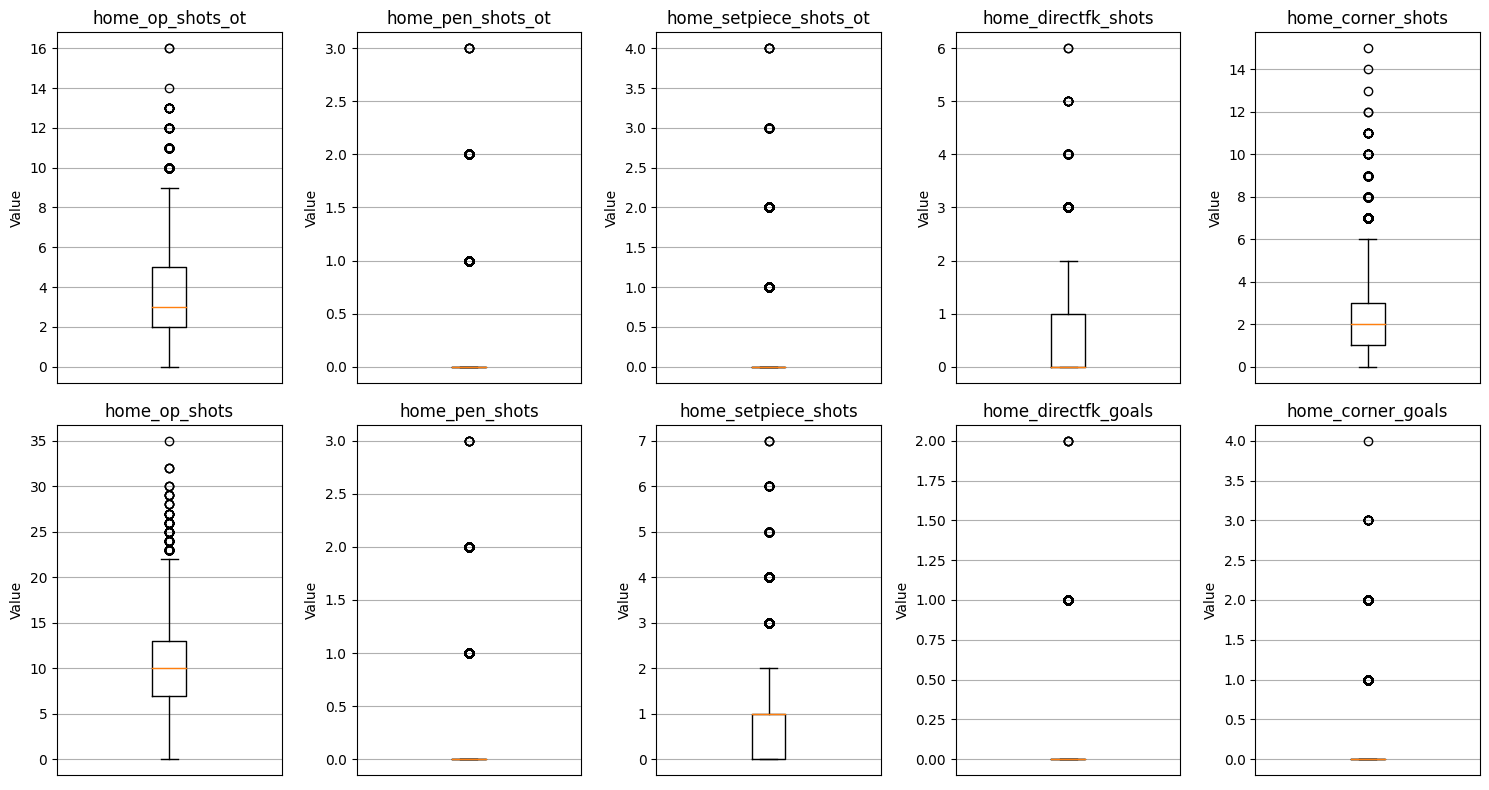

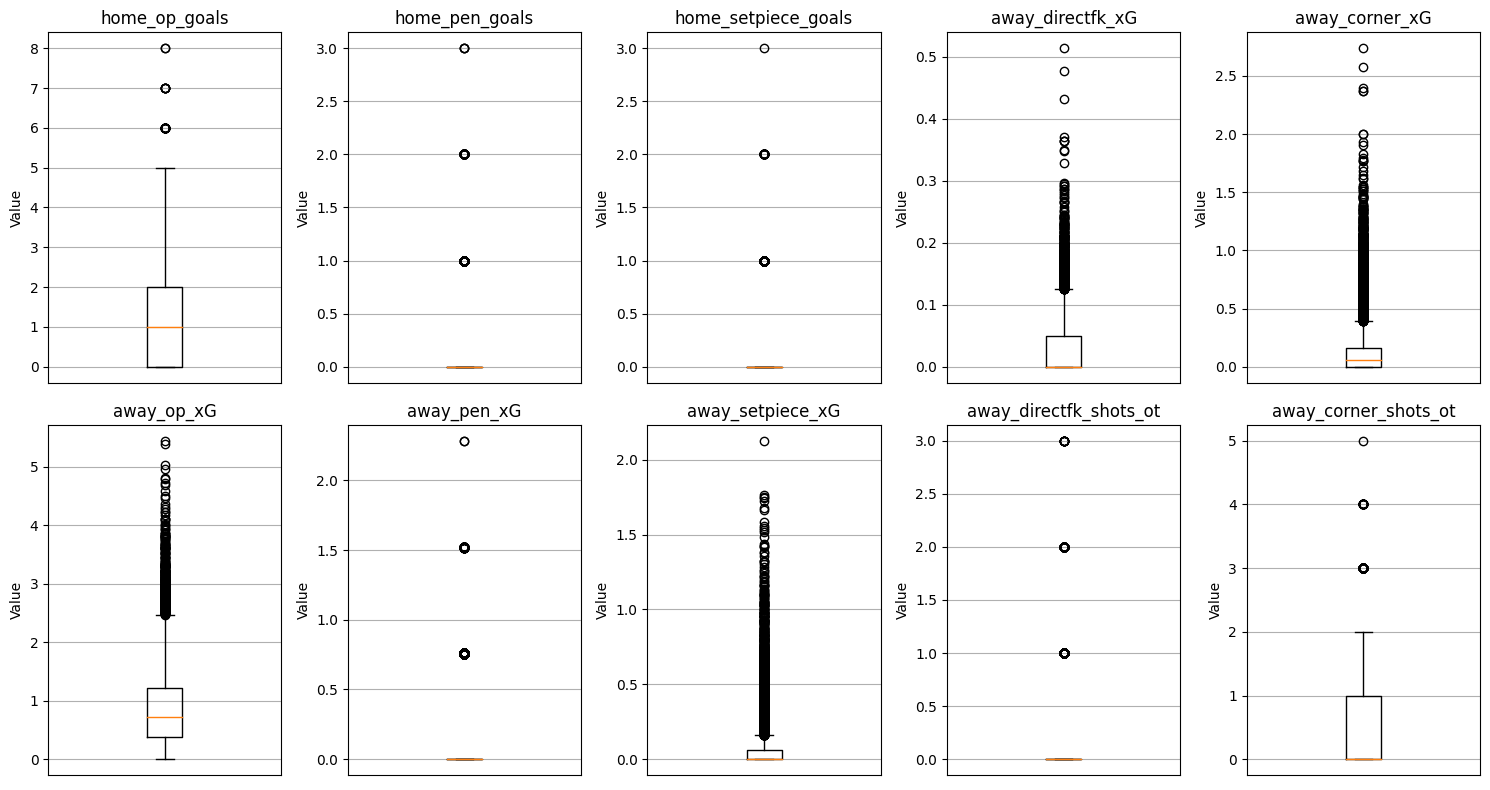

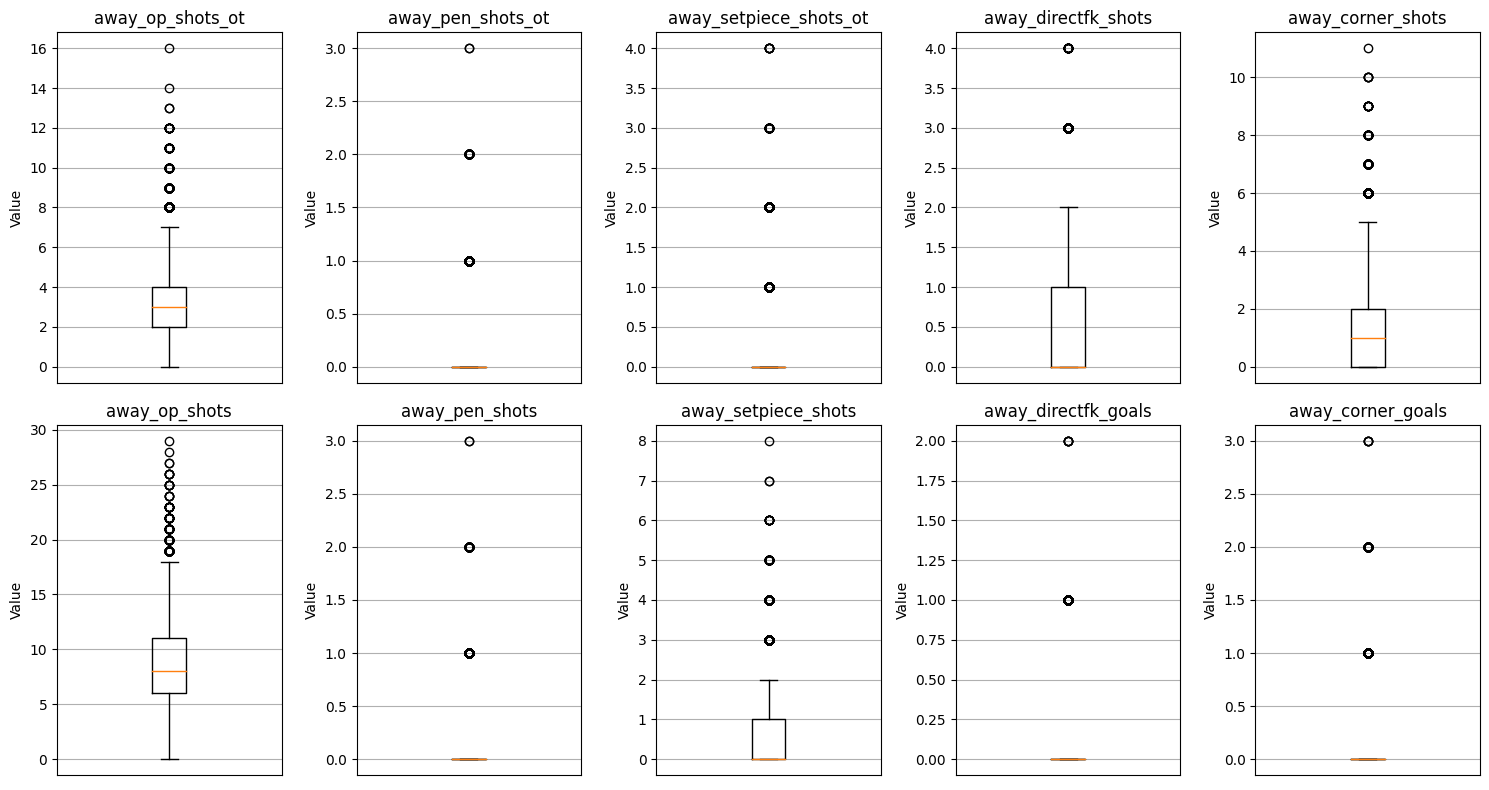

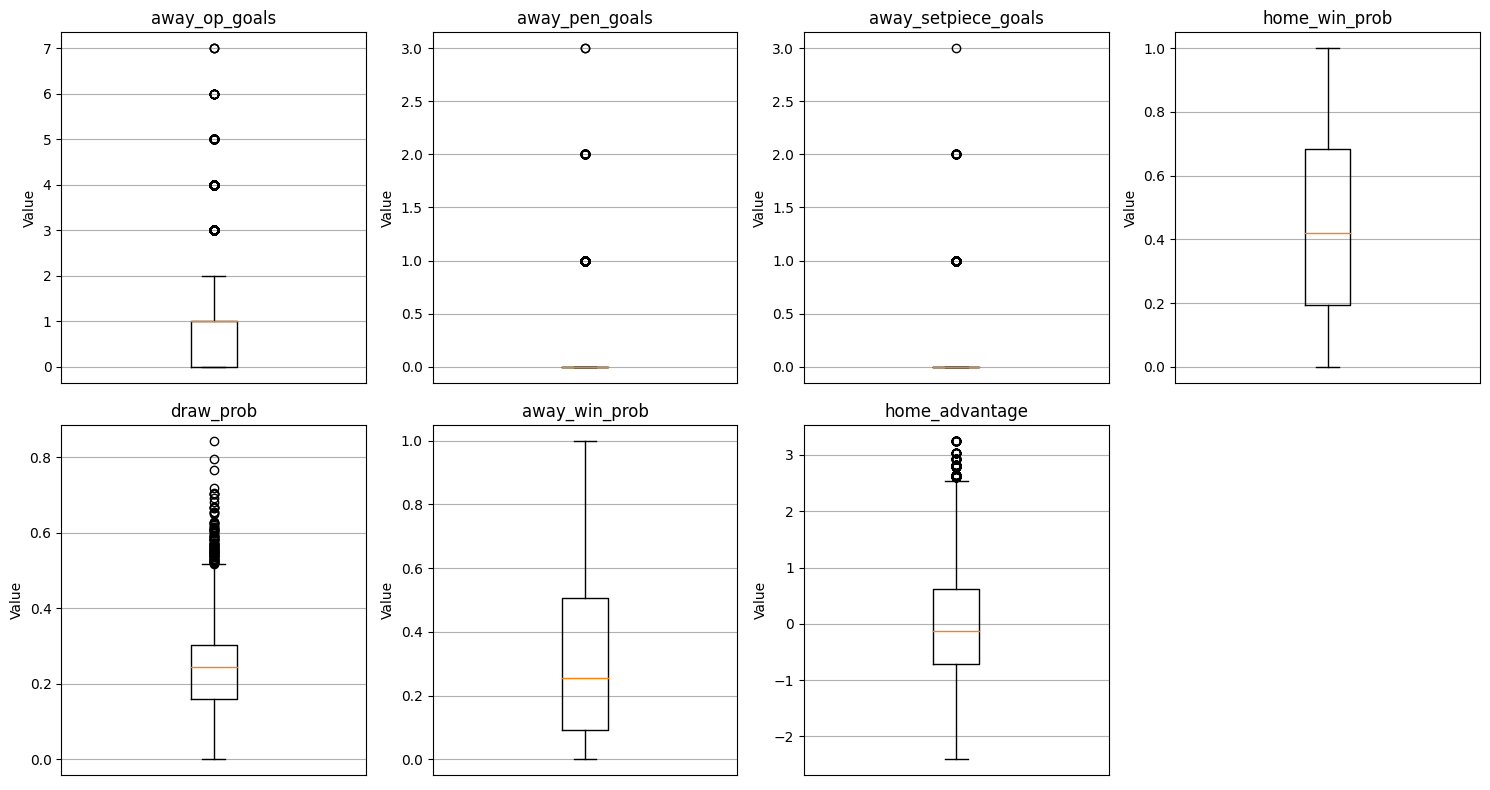

In [10]:
import matplotlib.pyplot as plt
# List of all columns you want to plot (example)
all_columns = df.columns.tolist()

# Number of columns per figure
columns_per_figure = 10

# Calculate the number of figures needed
num_figures = int(np.ceil(len(all_columns) / columns_per_figure))

# Loop through the figures
for figure_index in range(num_figures):
    plt.figure(figsize=(15, 8))
    start_index = figure_index * columns_per_figure
    end_index = start_index + columns_per_figure
    columns_to_plot = all_columns[start_index:end_index]
    num_columns_to_plot = len(columns_to_plot)

    for idx, column in enumerate(columns_to_plot):
        plt.subplot(2, num_columns_to_plot // 2 + num_columns_to_plot % 2, idx + 1)
        plt.boxplot(df[column])
        plt.title(column)
        plt.ylabel('Value')
        plt.xticks([])  # Remove x-axis labels for better clarity
        plt.grid(True)

    plt.tight_layout()
    plt.show()

In [2]:
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import RobustScaler

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=25,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)

# Define the input features and target columns
input_features = ['home_directfk_xG', 'home_corner_xG', 'home_op_xG', 'home_pen_xG',
       'home_setpiece_xG', 'home_directfk_shots_ot', 'home_corner_shots_ot',
       'home_op_shots_ot', 'home_pen_shots_ot', 'home_setpiece_shots_ot',
       'home_directfk_shots', 'home_corner_shots', 'home_op_shots',
       'home_pen_shots', 'home_setpiece_shots', 'home_directfk_goals',
       'home_corner_goals', 'home_op_goals', 'home_pen_goals',
       'home_setpiece_goals', 'away_directfk_xG', 'away_corner_xG',
       'away_op_xG', 'away_pen_xG', 'away_setpiece_xG',
       'away_directfk_shots_ot', 'away_corner_shots_ot', 'away_op_shots_ot',
       'away_pen_shots_ot', 'away_setpiece_shots_ot', 'away_directfk_shots',
       'away_corner_shots', 'away_op_shots', 'away_pen_shots',
       'away_setpiece_shots','away_directfk_goals','away_corner_shots', 'away_op_shots', 'away_pen_shots',
       'away_setpiece_shots', 'away_directfk_goals',
       'away_corner_goals', 'away_op_goals', 'away_pen_goals',
       'away_setpiece_goals','home_advantage']


target_columns = ['home_win_prob', 'draw_prob','away_win_prob']

# Prepare the input data and target labels
X = df[input_features].values
y = df[target_columns].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

# Standardize the input data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Build the neural network model with L2 regularization
model = keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(12, activation='relu', kernel_regularizer=l2(0.01)),   # L2 regularization added
    layers.Dropout(0.3),
    layers.Dense(6, activation='relu', kernel_regularizer=l2(0.01)),   # L2 regularization added
    layers.Dropout(0.2),
    layers.Dense(3, activation='softmax')  # Output layer with softmax activation
])


# Define the learning rate
learning_rate = 0.001
amsgrad = False
# Create the optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate,amsgrad=amsgrad)

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=300, batch_size=16,validation_data=(X_test_scaled, y_test))

# Evaluate the model on the test data
test_loss = model.evaluate(X_test_scaled, y_test)
print(f"Test loss: {test_loss:.4f}")

# Print training loss for each epoch
training_loss = history.history['loss']
for epoch, train_loss in enumerate(training_loss):
    print(f"Epoch {epoch + 1}: Train loss = {train_loss:.4f}")

# Make predictions on the test data
predictions = model.predict(X_test_scaled)

# Save the trained model and the scaler
model.save('MaldiniNet_minmax.h5')

print("Model saved successfully.")

Epoch 1/300
614/614 [==============================] - 3s 2ms/step - loss: 0.1107 - val_loss: 0.0533
Epoch 2/300
614/614 [==============================] - 1s 2ms/step - loss: 0.0473 - val_loss: 0.0410
Epoch 3/300
614/614 [==============================] - 1s 2ms/step - loss: 0.0424 - val_loss: 0.0365
Epoch 4/300
614/614 [==============================] - 1s 2ms/step - loss: 0.0398 - val_loss: 0.0340
Epoch 5/300
614/614 [==============================] - 1s 2ms/step - loss: 0.0372 - val_loss: 0.0312
Epoch 6/300
614/614 [==============================] - 1s 2ms/step - loss: 0.0355 - val_loss: 0.0292
Epoch 7/300
614/614 [==============================] - 1s 2ms/step - loss: 0.0342 - val_loss: 0.0275
Epoch 8/300
614/614 [==============================] - 1s 2ms/step - loss: 0.0328 - val_loss: 0.0266
Epoch 9/300
614/614 [==============================] - 1s 2ms/step - loss: 0.0315 - val_loss: 0.0255
Epoch 10/300
614/614 [==============================] - 1s 2ms/step - loss: 0.0314 - val_lo

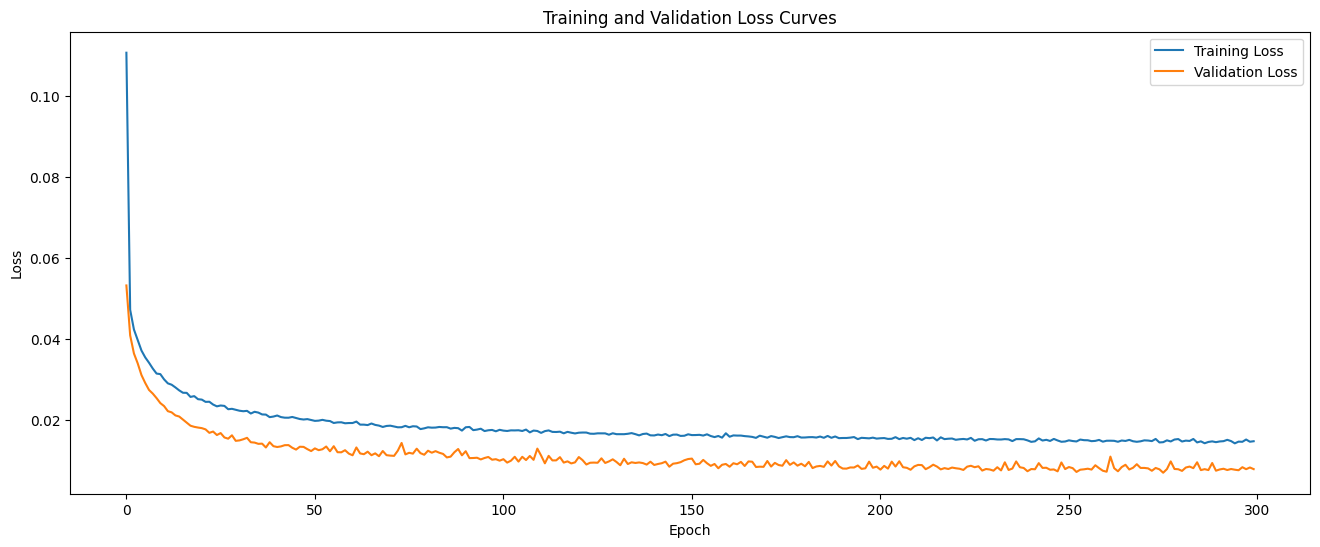

In [3]:
import matplotlib.pyplot as plt


# Plot the loss curves
plt.figure(figsize=(16, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

In [4]:
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import RobustScaler

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=25,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)

# Define the input features and target columns
input_features = ['home_directfk_xG', 'home_corner_xG', 'home_op_xG', 'home_pen_xG',
       'home_setpiece_xG', 'home_directfk_shots_ot', 'home_corner_shots_ot',
       'home_op_shots_ot', 'home_pen_shots_ot', 'home_setpiece_shots_ot',
       'home_directfk_shots', 'home_corner_shots', 'home_op_shots',
       'home_pen_shots', 'home_setpiece_shots', 'home_directfk_goals',
       'home_corner_goals', 'home_op_goals', 'home_pen_goals',
       'home_setpiece_goals', 'away_directfk_xG', 'away_corner_xG',
       'away_op_xG', 'away_pen_xG', 'away_setpiece_xG',
       'away_directfk_shots_ot', 'away_corner_shots_ot', 'away_op_shots_ot',
       'away_pen_shots_ot', 'away_setpiece_shots_ot', 'away_directfk_shots',
       'away_corner_shots', 'away_op_shots', 'away_pen_shots',
       'away_setpiece_shots','away_directfk_goals','away_corner_shots', 'away_op_shots', 'away_pen_shots',
       'away_setpiece_shots', 'away_directfk_goals',
       'away_corner_goals', 'away_op_goals', 'away_pen_goals',
       'away_setpiece_goals','home_advantage']


target_columns = ['home_win_prob', 'draw_prob','away_win_prob']

# Prepare the input data and target labels
X = df[input_features].values
y = df[target_columns].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

# Standardize the input data
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Build the neural network model with L2 regularization
model = keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(12, activation='relu', kernel_regularizer=l2(0.01)),   # L2 regularization added
    layers.Dropout(0.3),
    layers.Dense(6, activation='relu', kernel_regularizer=l2(0.01)),   # L2 regularization added
    layers.Dropout(0.2),
    layers.Dense(3, activation='softmax')  # Output layer with softmax activation
])


# Define the learning rate
learning_rate = 0.001
amsgrad = False
# Create the optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate,amsgrad=amsgrad)

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=300, batch_size=16,validation_data=(X_test_scaled, y_test))

# Evaluate the model on the test data
test_loss = model.evaluate(X_test_scaled, y_test)
print(f"Test loss: {test_loss:.4f}")

# Print training loss for each epoch
training_loss = history.history['loss']
for epoch, train_loss in enumerate(training_loss):
    print(f"Epoch {epoch + 1}: Train loss = {train_loss:.4f}")

# Make predictions on the test data
predictions = model.predict(X_test_scaled)

# Save the trained model and the scaler
model.save('MaldiniNet_robust.h5')

print("Model saved successfully.")

Epoch 1/300
614/614 [==============================] - 2s 2ms/step - loss: 0.1123 - val_loss: 0.0288
Epoch 2/300
614/614 [==============================] - 1s 2ms/step - loss: 0.0271 - val_loss: 0.0168
Epoch 3/300
614/614 [==============================] - 1s 2ms/step - loss: 0.0222 - val_loss: 0.0146
Epoch 4/300
614/614 [==============================] - 1s 2ms/step - loss: 0.0210 - val_loss: 0.0131
Epoch 5/300
614/614 [==============================] - 1s 2ms/step - loss: 0.0196 - val_loss: 0.0123
Epoch 6/300
614/614 [==============================] - 1s 2ms/step - loss: 0.0190 - val_loss: 0.0117
Epoch 7/300
614/614 [==============================] - 1s 2ms/step - loss: 0.0183 - val_loss: 0.0115
Epoch 8/300
614/614 [==============================] - 1s 2ms/step - loss: 0.0181 - val_loss: 0.0114
Epoch 9/300
614/614 [==============================] - 1s 2ms/step - loss: 0.0170 - val_loss: 0.0105
Epoch 10/300
614/614 [==============================] - 1s 2ms/step - loss: 0.0168 - val_lo

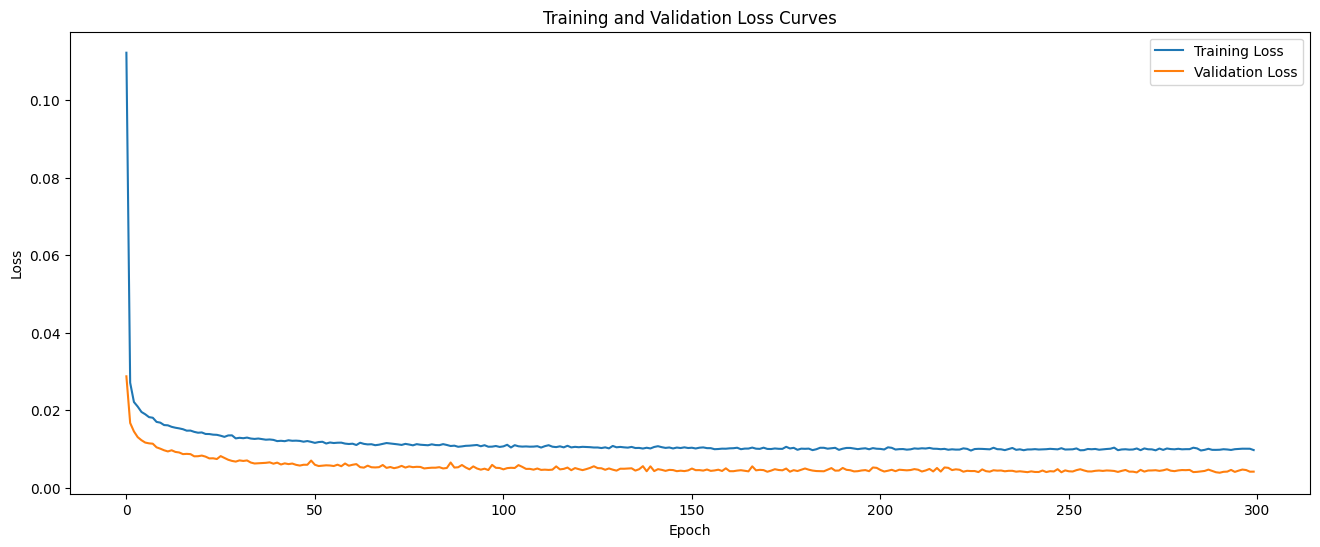

In [5]:
# Plot the loss curves
plt.figure(figsize=(16, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()